In [1]:
%matplotlib widget
import numpy as np
import xarray as xr
import scipy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
ani = None

In [2]:
# Input parameters

# Spatial domain grid
x_grid = np.arange(1,201,1)
n_z = x_grid.shape[0]

# Frequency domain grid
# f = np.logspace(-2,1, num=200)[np.newaxis,:]
# wind does not have to be generated up to higher frequencies, 
# as the energy in these bands is negligible
fs_w = 10 # Hz, Wind sample rate
# sample rate is adjusted by zero padding the fft
fs_m = 100 # Hz, Model sample rate

duration = 36 # seconds
if duration is None:
    N = 2**17
    duration = N / fs_w
else:
    N = int(duration * fs_w)

N_m =  int(duration * fs_m)

print(f'A total of {N} samples of the windfield will be generated at {fs_w} Hz for a total duration of {duration} seconds. It will be upsampled to {fs_m} Hz')

# 2**17 samples @ 100 Hz -> 21:50.72 minutes
# takes 1min 42 (CPSD assembly) + 2min 20s (CPSD decomposition) + 1min 59s(Fourier coefficients assembly) + 1.4s (FFT) = 6min 2s; peaks at 270 GB RAM
f_w = np.fft.rfftfreq(N, 1/fs_w)[:,np.newaxis]
n_fw = f_w.shape[0]
delta_fw = f_w[1, 0] - f_w[0, 0]

# random phases of the windfield
phi_um = np.random.random((n_fw, n_z)) * 2 * np.pi 
phi_vm = np.random.random((n_fw, n_z)) * 2 * np.pi 
phi_wm = np.random.random((n_fw, n_z)) * 2 * np.pi 

A total of 360 samples of the windfield will be generated at 10 Hz for a total duration of 36 seconds. It will be upsampled to 100 Hz


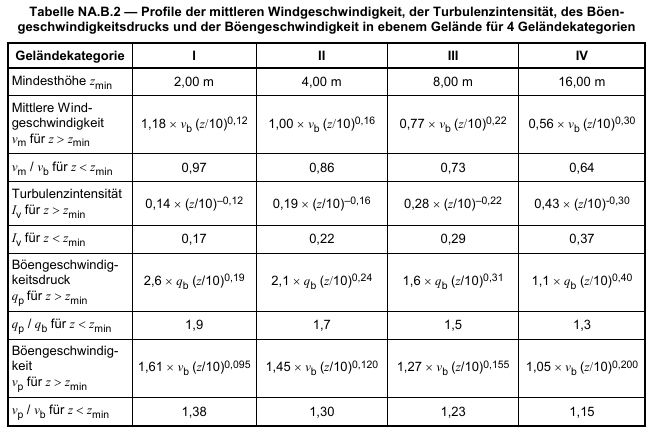
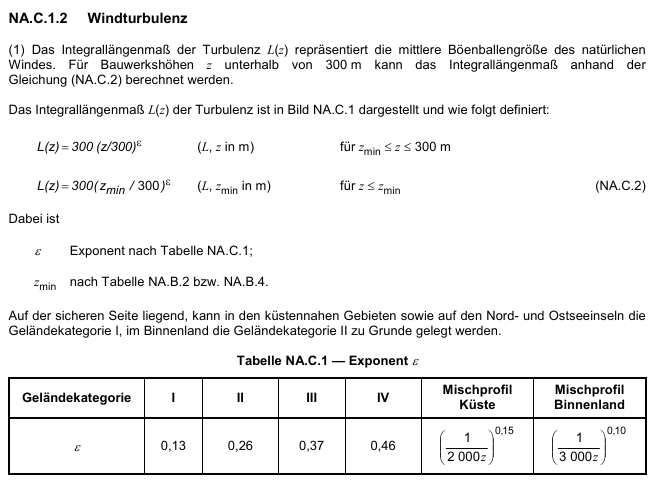

In [3]:
category=3
zone=2

# Geländekategorie I - IV
z_min = [None,2,4,8,16][category]
z_0 = [None, 0.01,0.05,0.3,1.05][category] # Rauigkeitslänge
alpha = [None,0.12,0.16,0.22, 0.3][category]  # Profilexponent

# Windzone 1 - 4
v_b = [None, 22.5, 25.0, 27.5, 30][zone] # m/s Basiswindgeschwindigkeit (v_b = v_b0 in DE vgl. NA S. 5)

# Compute basic wind parameters according to DIN EN 1991-1-4 and corresponding NA    
# Werte nach Tab. NA.B.2
vm_fact = [None, 1.18, 1.00, 0.77, 0.56][category]
v_m = vm_fact * v_b * (x_grid/10)**alpha
vm_min = [None, 0.97, 0.86, 0.73, 0.64][category]
v_m[x_grid<=z_min] = vm_min * v_b

# v_m = 1*v_b*(x_grid/10)**0.16 # mittlere Windgeschwindigkeit (obere Formel ergaebe Faktor 1.0066803, daher die geringen Abweichungen)
Iv_fact = [None, 0.14,0.19,0.28,0.43][category]
I_v = Iv_fact*(x_grid/10)**(-alpha) # Turbulenzintensität [% der mittleren Windgeschwindigkeit] (? siehe unten)
Iv_min = [None, 0.17, 0.22, 0.29, 0.37][category]
I_v[x_grid<=z_min] = Iv_min

sigma_v = I_v * v_m # Standardabweichung der Turbulenz nach Gl. 4.7

eps = [None, 0.13, 0.26, 0.37, 0.46][category] # Exponent \epsilon nach Tabelle NA.C.1
L = (x_grid/300)**eps * 300 # Integrallängenmaß nach Gl. NA.C.2
L[x_grid<=z_min] = (z_min/300)**eps * 300


(Auto-)Leistungsdichtespektren der Windturbulenz $S_{uu}(f_n), S_{vv}(f_n), S_{ww}(f_n)$ nach Tabelle 4.1 [Clobes, 2008], siehe auch Bild NA.C.2 (abh. $\overline{U}(z), L_{ux}, I_{u}, f_w, \sigma$) werden für abgespannte Masten als unabhängig und Normalverteilt angesehen

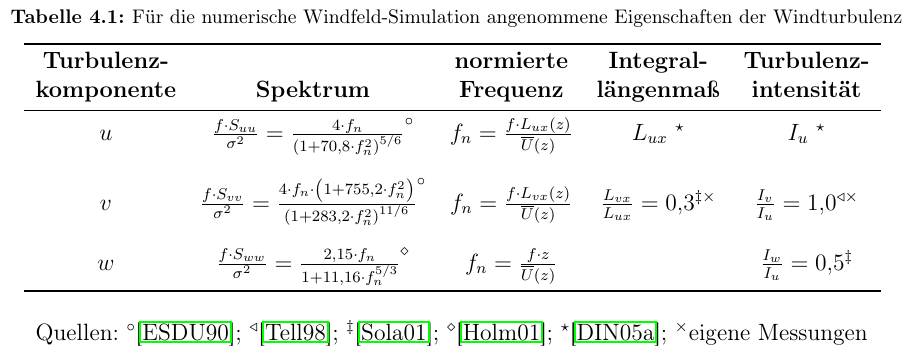

Kreuleistungsdichte zwischen zwei Punkten $k_1$ und $k_2$ bestimmt sich aus der Kohärenz $\operatorname{coh}_{k_{i,j}}^2(f) =  \frac{|S_{k_i k_j}|^2}{S_{k_i k_i}S_{k_jk_j}}$ (Phasenbeziehung fehlt! vernachlässigbar nach [Clobes, 2008])



In [10]:
# Compute basic wind parameters and auto spectral densitities according to Clobes 208

I_uu = I_v[np.newaxis, :]
I_vv = I_uu
# I_ww = 0.5 * I_uu

L_ux = L[np.newaxis, :]
L_vx = 0.3 * L_ux

# rename some parameters and also transpose column vectors
U_bar = v_m[np.newaxis, :]
sigma = sigma_v[np.newaxis, :]
z = x_grid[np.newaxis, :]

f_n = f_w * L_ux / U_bar
S_uu = 4 * f_n / (1 + 70.8 * f_n**2)**(5/6) / f_w * sigma**2
# S_uu[-1,N//4]=300

f_n = f_w * L_vx / U_bar
S_vv = 4 * f_n * (1 + 755.2 * f_n**2) / (1 + 283.2 * f_n**2)**(11 / 6) / f_w * sigma**2

# f_n = f_w * z / U_bar
# S_ww = 2.15 * f_n / (1 + 11.16 * f_n**(5 / 3)) / f_w * sigma**2


/tmp/ipykernel_6977/2122499533.py:16: RuntimeWarning: invalid value encountered in divide
  S_uu = 4 * f_n / (1 + 70.8 * f_n**2)**(5/6) / f_w * sigma**2
/tmp/ipykernel_6977/2122499533.py:20: RuntimeWarning: invalid value encountered in divide
  S_vv = 4 * f_n * (1 + 755.2 * f_n**2) / (1 + 283.2 * f_n**2)**(11 / 6) / f_w * sigma**2


laterale, longitudinale und verticale komponente werden als unabhaengig voneinander angenommen ($S_{uv} = S_{uw} = S_{wv} = 0$)

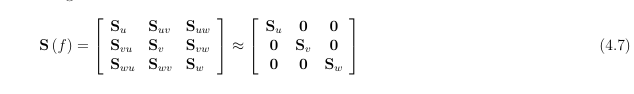


Kreuzleistungsdichtespektrum nach ESDCU91c
'
$$\mathbf{S}(f) = 
    \begin{bmatrix}
    S_{k_1 k_1}(f) & S_{k_1 k_2}(f) & \cdots & S_{k_1 k_n}(f)  \\
    S_{k_2 k_1}(f) & S_{k_2 k_2}(f) & \cdots & S_{k_2 k_n}(f)  \\
    \vdots         & \vdots         & \ddots & \vdots          \\
    S_{k_n k_1}(f) & S_{k_n k_2}(f) & \cdots & S_{k_n k_n }(f) \\
    \end{bmatrix}
$$
mit der Kohaerenz
$$\operatorname{coh}^2_{k_{i,j}} = \frac{|S_{k_i k_j}|^2}{S_{k_i k_i} S_{k_j k_j}}$$

$$\operatorname{coh}_{k_{i,j}} = \operatorname{exp}\left(\frac{-2 f \sqrt{C_{k,x}^2 (x_i - x_j)^2 + C_{k,y}^2 (y_i - y_j)^2 + C_{k,z}(z_i - z_j)^2}}{\overline{U}_i + \overline{U}_j}\right)$$

Die Decay-Parameter $C_{k,..}$ sind von der Geländerauigkeit und von der Höhe abhängig. Die Werte aus der Literatur streuen stark. 

Hier ist $z$ die Hoehenkomponente und $(x_i - x_j) = (y_i -y_j) = 0$. Die Turbulenzkomponenten $u$ und $v$ sind von Interesse.


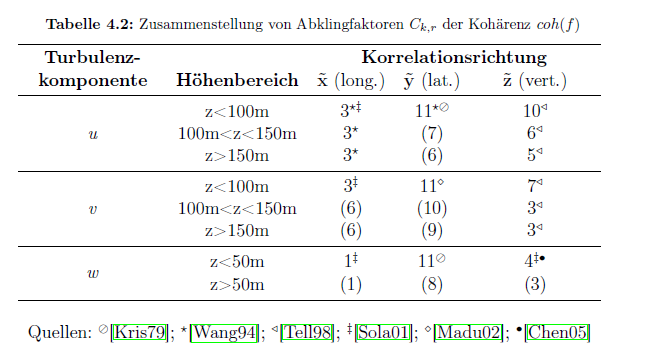

In [11]:
# CPSD assembly

S_uu_full_b = np.zeros((n_fw, n_z, n_z))
S_vv_full_b = np.zeros((n_fw, n_z, n_z,))
# S_ww_full_b = np.zeros((u + 1, n_z, n_fw))

for i in range(n_z):
    # print(i)
    for j in range(i + 1):
        # print('\t',j)
        if i==j: 
            S_uu_full_b[:, i - j, j] = S_uu[:, i]
            S_vv_full_b[:, i - j, j] = S_vv[:, i]
            # S_ww_full_b[:, i - j, j] = S_ww[:, i]
        else:

            delta_z = np.abs(x_grid[i] - x_grid[j])
            # if delta_z > 50 : continue
            mean_z = (x_grid[i] + x_grid[j]) / 2
            
            C_uz = 10
            C_vz = 7
            # C_wz = 4
            
            coh_u = np.exp(-2 * f_w[:, 0] * C_uz * delta_z / (U_bar[0, i] + U_bar[0, j])) 
            r = np.sqrt(coh_u**2 * S_uu[:, i] * S_uu[:, j])
            S_uu_full_b[:, i - j, j] = r #* np.exp(1j*phi)
            

            coh_v = np.exp(-2 * f_w[:, 0] * C_vz * delta_z / (U_bar[0, i] + U_bar[0, j])) 
            r = np.sqrt(coh_v**2 * S_vv[:, i] * S_vv[:, j])
            S_vv_full_b[:, i - j, j] = r
            

            # coh_w = np.exp(-2 * f_w[:, 0] * C_wz * delta_z / (U_bar[0, i] + U_bar[0, j]))
            # r = np.sqrt(coh_w**2 * S_ww[:, i] * S_ww[:, j])
            # S_ww_full_b[:, i - j, j] = r
            
            
if f_w[0,0] == 0:
    S_uu_full_b[0, :, :] = 0
    S_vv_full_b[0, :, :] = 0
    # S_ww_full_b[0,:,:] = 0
    S_uu_full_b[0, 0, :] = np.ones(n_z)*1e-10
    S_vv_full_b[0, 0, :] = np.ones(n_z)*1e-10
    # S_ww_full_b[0, 0, :] = np.ones(n_z)*1e-10

In [12]:
# Decompose Cross-spectral densities

S_uu_chol_b = np.empty_like(S_uu_full_b)
S_vv_chol_b = np.empty_like(S_vv_full_b)
# S_ww_chol_b = np.empty_like(S_ww_full_b)

u_target = 10
S_uu_chol_b[0, :u_target, :] = scipy.linalg.cholesky_banded(S_uu_full_b[0, :u_target,:], lower=True)
S_vv_chol_b[0, :u_target, :] = scipy.linalg.cholesky_banded(S_vv_full_b[0, :u_target,:], lower=True)
# S_ww_chol_b[0, :u_target, :] = scipy.linalg.cholesky_banded(S_ww_full_b[0, :u_target, :], lower=True)

all_u = np.zeros((n_fw))
for k in range(n_fw - 1, 0, -1):
    # for lower frequencies, we have stronger coherence and need more off-diagonals
    # we iterate backwards in frequency, increasing u when needed
    # for the first frequency we usually need all bands
    while True:
        try:
            S_uu_chol_b[k, :u_target, :] = scipy.linalg.cholesky_banded(S_uu_full_b[k, :u_target, :], lower=True)
            S_vv_chol_b[k, :u_target, :] = scipy.linalg.cholesky_banded(S_vv_full_b[k, :u_target, :], lower=True)
            # S_ww_chol_b[k, :u_target, :] = scipy.linalg.cholesky_banded(S_ww_full_b[k, :u_target, :], lower=True)
            all_u[k] = u_target
            break
        # catch non-positive definite correlation matrices
        except Exception as e:
            u_target += 1
            if u_target > n_z:
                print(k, u_target,  e)

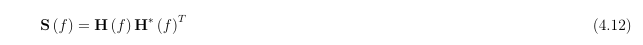

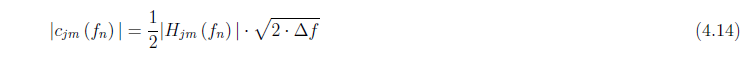

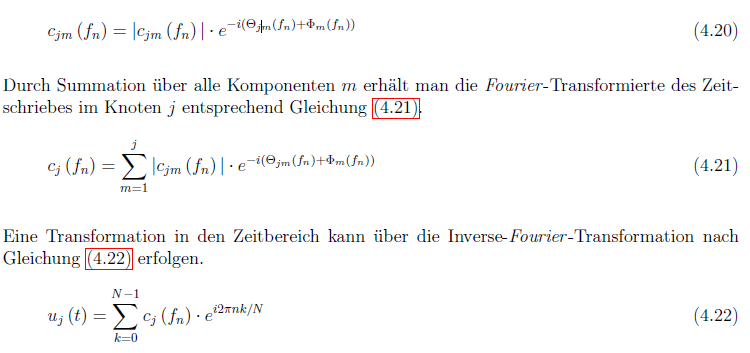

In [13]:
# Fourier coefficient assembly
c_uj = np.zeros((n_fw, n_z), dtype=complex)
c_vj = np.zeros((n_fw, n_z), dtype=complex)
# c_wj = np.zeros((n_fw, n_z), dtype=complex)
delta_omega = delta_fw * 2 * np.pi
# last part is the most expensive as sin(phi_um) has to be repeated n_z times along axis=0)
c_uj_b = np.flip(np.abs(S_uu_chol_b, where=S_uu_chol_b!=0) * np.sqrt(2* delta_omega) * np.exp(1j * phi_um[:,np.newaxis, :]), axis=2)
c_vj_b = np.flip(np.abs(S_vv_chol_b, where=S_vv_chol_b!=0) * np.sqrt(2* delta_omega) * np.exp(1j * phi_vm[:,np.newaxis, :]), axis=2)
for j in range(n_z):
    c_uj[:, j] = np.trace(c_uj_b, offset=n_z - j - 1, axis1=1, axis2=2)
    c_vj[:, j] = np.trace(c_vj_b, offset=n_z - j - 1, axis1=1, axis2=2)

In [14]:
# Inverse FFT
u_j = np.zeros((N_m, n_z))
v_j = np.zeros((N_m, n_z))
# w_j = np.zeros((N_m, n_z))
for j in range(n_z):        
    u_j[:, j] = np.fft.irfft(c_uj[:, j], n=N_m, norm="forward")/2/np.pi # delta_omega already considered by norm (?) # d="backward", "ortho", "forward"
    v_j[:, j] = np.fft.irfft(c_vj[:, j], n=N_m, norm="forward")/2/np.pi # d="backward", "ortho", "forward"
    # w_j[:, j] = np.fft.irfft(c_wj[:, j], n=N_m, norm="forward") # "backward", "ortho", "forward"

# check, that we are in the right order of magnitude
# plt.figure()
# m,b = np.polyfit(I_v[5:], (np.std(v_j, axis=1)/v_m)[5:], 1)
# display(m,b, 1/m, duration, N_m,n_fw)
# plt.scatter(I_v, (np.std(v_j, axis=1)/v_m))

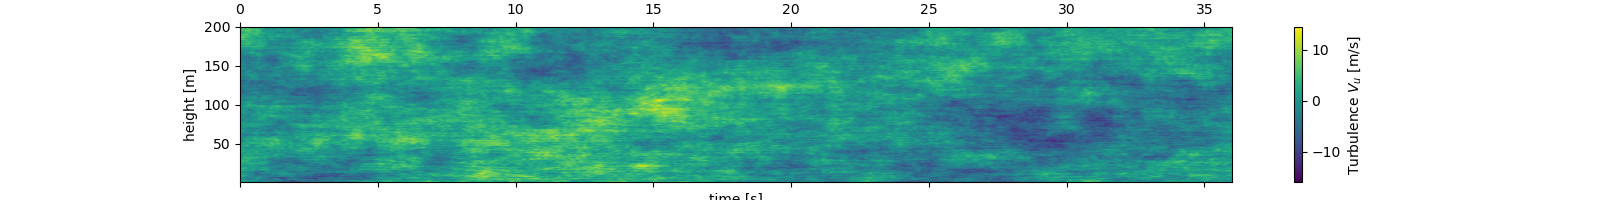

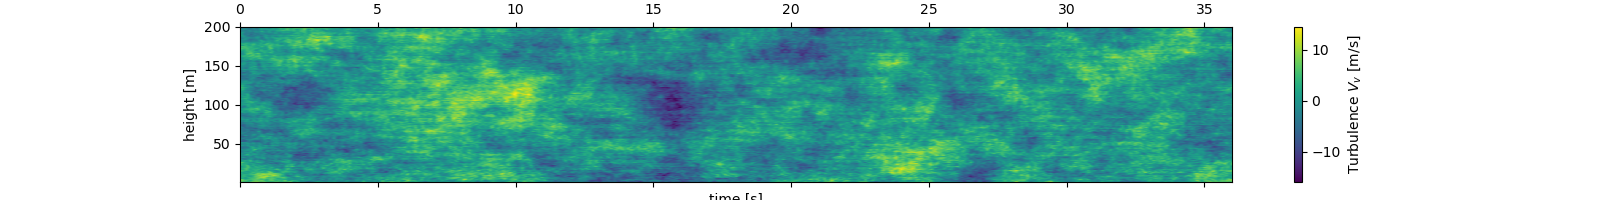

In [15]:
vmin = min([u_j.min(), v_j.min()])#, w_j.min()])
vmax = max([u_j.max(), v_j.max()])#, w_j.max()])

plt.matshow(u_j.T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax)
plt.xlabel('time [s]')
plt.ylabel('height [m]')
cbar = plt.colorbar()
cbar.set_label('Turbulence $V_u$ [m/s]')
plt.matshow(v_j.T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax)
plt.xlabel('time [s]')
plt.ylabel('height [m]')
cbar = plt.colorbar()
cbar.set_label('Turbulence $V_v$ [m/s]')
# plt.matshow(w_j, origin='lower', aspect='auto', extent=(0, f_w.shape[1]/fs, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax)
# plt.xlabel('time [s]')
# plt.ylabel('height [m]')
# cbar = plt.colorbar()
# cbar.set_label('Turbulence $V_w$ [m/s]')

# Kraftberechnung

### Auszuege aus EN 1991-1-4

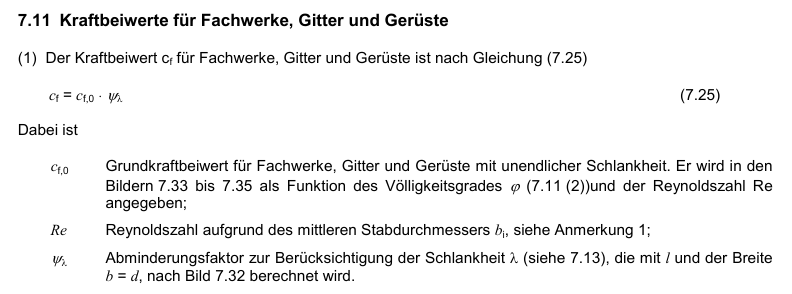

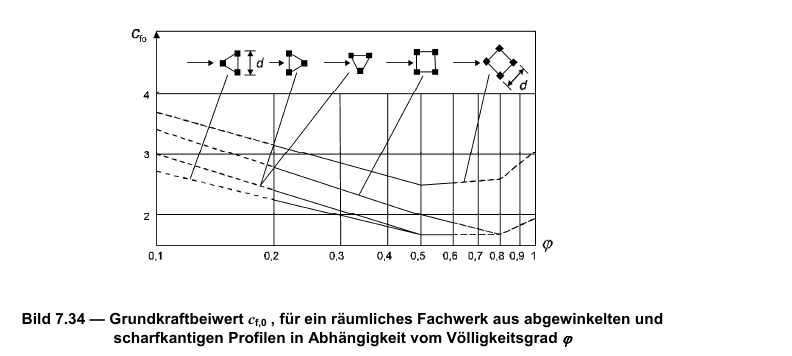

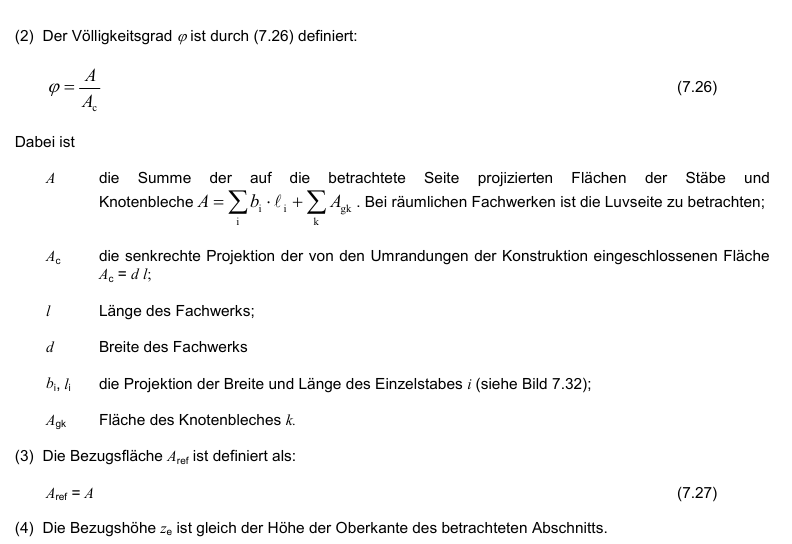

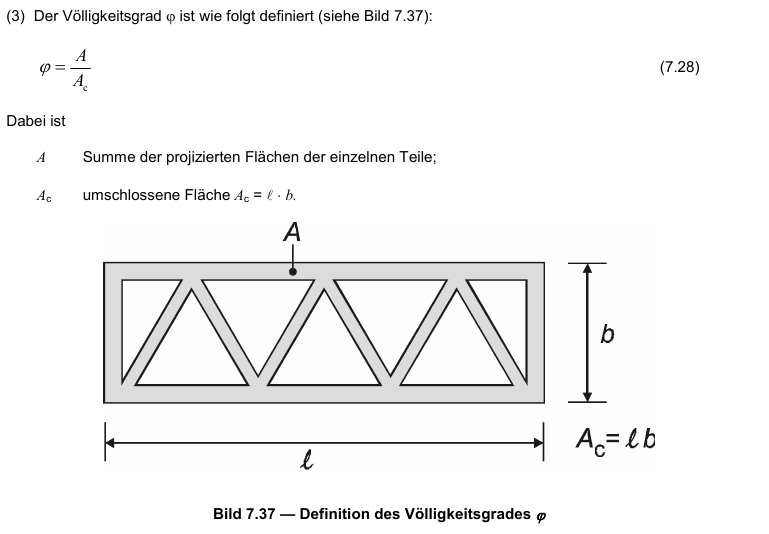

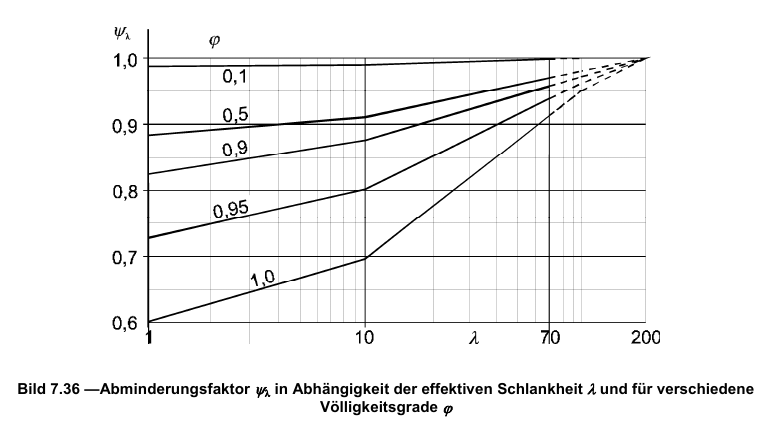

### Gewaehltes Fachwerk:

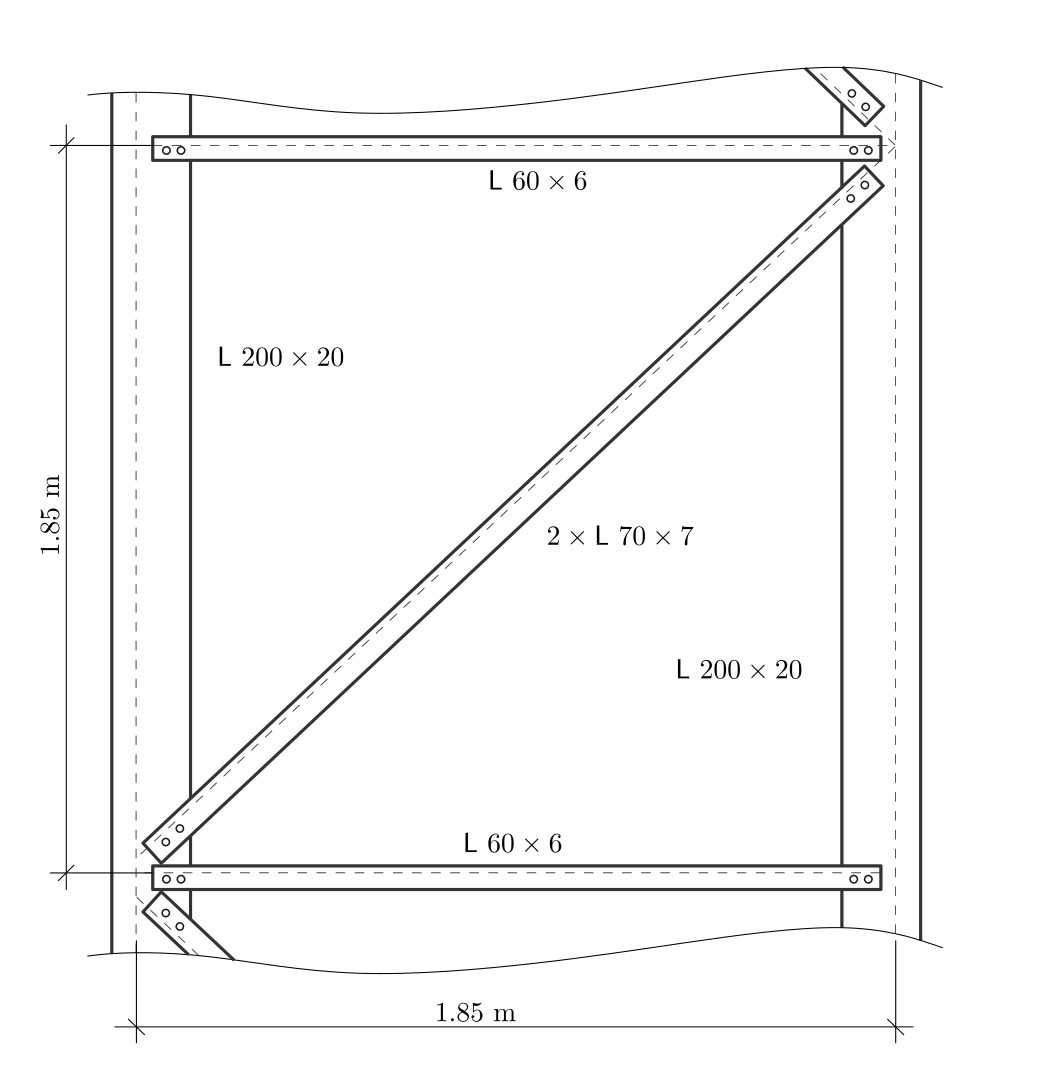

Die Querschnitte wurden gewaehlt, um mit den bisherigen Berechnungen kompatibel zu sein, was Masse je Laengeneinheit und Steifigkeiten in beiden lateralen Richtungen angeht.


Getrennte Betrachtung der longitudinalen und lateralen Anstroemung (Annahme nicht belegt durch Literatur)

Voelligkeitsgrad je Schuss:

$A_c = 1.85^2 = 3.4225$ m²

$A = 0.2 \cdot 1.85 + 0.2\cdot1.85 + \sqrt{2\cdot1.85^2}\cdot0.07 + 0.06\cdot1.85 = 0.37 + 0.37 + 0.183141 + 0.111 = 1.0341$ m²

$\phi = \frac{1.0341}{3.4225} = 0.3021$

Effektive Schlankheit $\psi_\lambda$ nach Tabelle 7.16:

$l = 200$ m, $b=1.85$ m

$\lambda = \min(1.4 \frac{l}{b} = 151.35, 70) = 70$

$\psi_\lambda = 0.98385$ linearly interpolated

Grundkraftbeiwert $c_{f,0}$ (Rechteckiges Fachwerk, senkrechte Anstroemung):

$c_{f0} = 2.4$

Kraftbeiwert:

$c_f = c_{f0} \psi_\lambda = 2.36124$



We assume here, that we can simply use $q_b = \frac{1}{2} \rho v_b^2$ to compute the pressure $q_p(z_e) \rightarrow q_{p,j}(t) = \frac{1}{2} \rho u_j^2(t)$ from our computed wind speeds $u_j(t)$

$F_{w,j}(t) = c_sc_d \cdot c_f \cdot q_{p,j}(t) \cdot A_\mathrm{ref}$

We assume $c_s c_d = 1$

In [16]:
# q_b = 0.5*\rho*v_b^2$
# u_j_ = u_j +  v_m[:,np.newaxis]
u_j_ = u_j
q_buj = 0.5*1.25*u_j_**2*np.sign(u_j_)
q_bvj = 0.5*1.25*v_j**2*np.sign(v_j)
# F_w = c_sc_d*c_f*q_p*A_ref
# A_ref Lasteinzugsflaeche des Knotens
delta_x = x_grid[1]- x_grid[0]

F_uj = 1.0 * 2.36124 * q_buj * delta_x * 1.85
F_vj = 1.0 * 2.36124 * q_bvj * delta_x * 1.85

lim = np.max([-np.min(F_uj), np.max(F_uj), -np.min(F_vj), np.max(F_vj)])

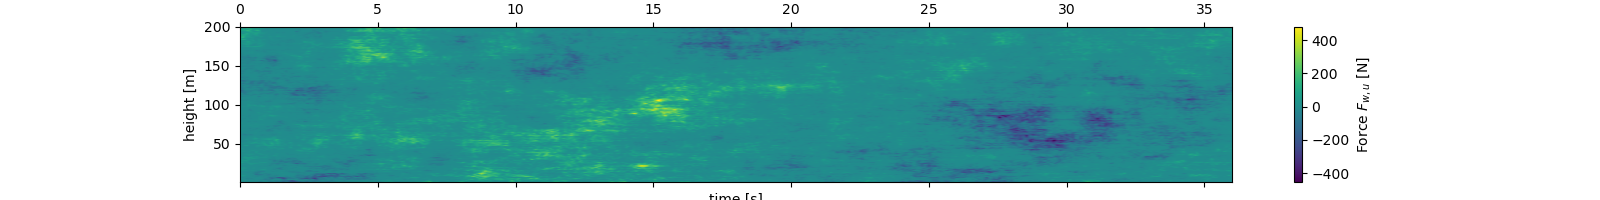

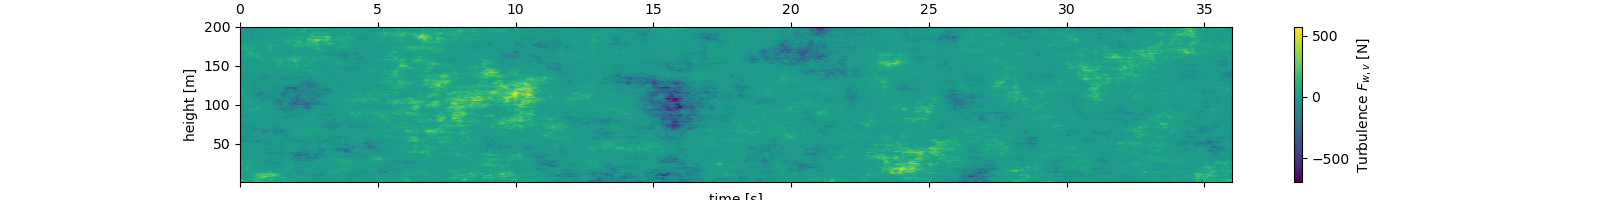

In [18]:
# plt.matshow(F_uj, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=-lim, vmax=lim)
plt.matshow(F_uj.T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]))
plt.xlabel('time [s]')
plt.ylabel('height [m]')
cbar = plt.colorbar()
cbar.set_label('Force $F_{w,u}$ [N]')
plt.matshow(F_vj.T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]))#, vmin=-lim, vmax=lim)
plt.xlabel('time [s]')
plt.ylabel('height [m]')
cbar = plt.colorbar()
cbar.set_label('Turbulence $F_{w,v}$ [N]')

### Empirische Daten vom Sendeturm Geyer

In [13]:
stats_wind = xr.load_dataset('/usr/scratch4/sima9999/work/stats_wind.nc')

'The parameters of the Weibull distribution are estimated from Anemometer Wg as $k=2.281$ and $\\lambda=7.204$'

'The basic wind speed that is exceeded with a probability of 2% is estimated as 13.45'

'The basic wind speed according to EN 1991 (zone II, category III) should be 31.95'

'The parameters of the Weibull distribution are estimated from Anemometer Wg_top as $k=1.983$ and $\\lambda=8.865$'

'The basic wind speed that is exceeded with a probability of 2% is estimated as 17.91'

'The basic wind speed according to EN 1991 (zone II, category III) should be 37.21'

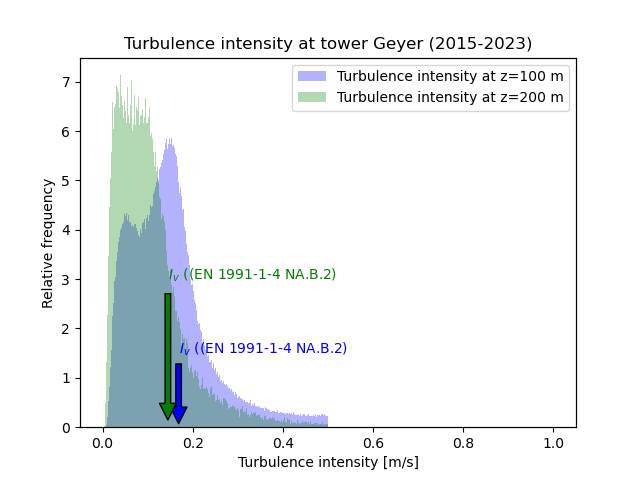

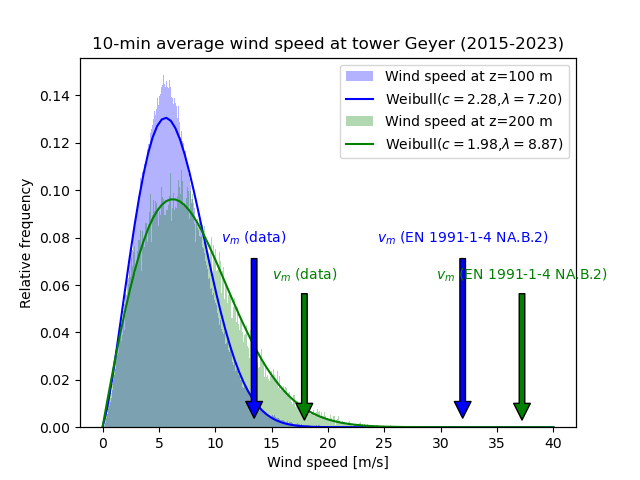

In [34]:
plt.figure()
ax = plt.subplot()
ax2 = plt.twinx()
plt.figure()
ax3 = plt.subplot()
ax4 = plt.twinx()
for name, z, color in [('Wg', 100, 'blue'),('Wg_top', 200, 'green')]:
    Wgds = stats_wind.sel(channels=name)
    Wgds = Wgds.where(Wgds['error']==0)
    tenminavg = Wgds['mean'].data           
    var = Wgds['var'].data                             
    ind = np.logical_and(~np.isnan(tenminavg.data), np.log(tenminavg.data)>-2)
    ind = np.logical_and(ind, np.sqrt(var)/tenminavg<=0.5)
    tenminavg = tenminavg[ind]
    var = var[ind]
    Iv = np.sqrt(var)/tenminavg


    ax.hist(tenminavg, bins=500, density=True, color=color, alpha=0.3, label=f'Wind speed at z={z} m')

    param=scipy.stats.weibull_min.fit(tenminavg, floc=0) # fit the sample data

    x=np.linspace(0,40,100)

    pdf_fitted = scipy.stats.weibull_min.pdf(x, param[0],
                                         # loc=param[1], 
                                         scale=param[2]
                                        ) # fitted distribution

    ax.plot(x,pdf_fitted,color=color, label=f'Weibull($c={param[0]:1.2f}$,$\lambda={param[2]:1.2f}$)')
    display(f'The parameters of the Weibull distribution are estimated from Anemometer {name} as $k={param[0]:1.3f}$ and $\\lambda={param[2]:1.3f}$')

    # vb0=scipy.stats.weibull_min.ppf(0.98, param[0], scale=param[2])
    vb0=np.quantile(tenminavg,(0.98))
    ax2.annotate('$v_m$ (data)', (vb0,0),(vb0,0.4-0.001*z+0.2), color=color, ha='center',
            arrowprops=dict(facecolor=color, shrink=0.05))
    display(f'The basic wind speed that is exceeded with a probability of 2% is estimated as {vb0:1.2f}')
    vben = 0.77*25*(z/10)**0.22
    ax2.annotate('$v_m$ (EN 1991-1-4 NA.B.2)', (vben,0),(vben,0.4-0.001*z+0.2), color=color, ha='center',
            arrowprops=dict(facecolor=color, shrink=0.05))
    display(f'The basic wind speed according to EN 1991 (zone II, category III) should be {vben:1.2f}')
    
    ax3.hist(Iv, bins=np.linspace(0,1,500),density=True,  color=color, alpha=0.3, label=f'Turbulence intensity at z={z} m')
    iven = 0.28*(z/10)**(-0.22)
    ax4.annotate('$I_v$ ((EN 1991-1-4 NA.B.2)', (iven,0),(iven,0.002*z), color=color, ha='left',
            arrowprops=dict(facecolor=color, shrink=0.05))
    
    
ax.legend()
ax3.legend()
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Relative frequency')
ax3.set_xlabel('Turbulence intensity [m/s]')
ax3.set_ylabel('Relative frequency')
ax2.set_ylim((0,1))
ax2.set_yticks([])
ax4.set_ylim((0,1))
ax4.set_yticks([])
ax.set_title('10-min average wind speed at tower Geyer (2015-2023)')
ax3.set_title('Turbulence intensity at tower Geyer (2015-2023)')
plt.show()

array([2.26852002, 0.        , 5.61940069])

array([2.29590668, 0.        , 5.65399573])

PearsonRResult(statistic=0.03309034588051221, pvalue=0.862188284532753)

'The parameters of the Weibull distribution are estimated from Anemometer Wg as $k=2.281$ and $\\lambda=5.638$'

array([1.94743055, 0.        , 5.8987455 ])

array([2.01503731, 0.        , 6.00284738])

PearsonRResult(statistic=0.45239419972808087, pvalue=0.012071462556646017)

'The parameters of the Weibull distribution are estimated from Anemometer Wg_top as $k=1.983$ and $\\lambda=5.956$'

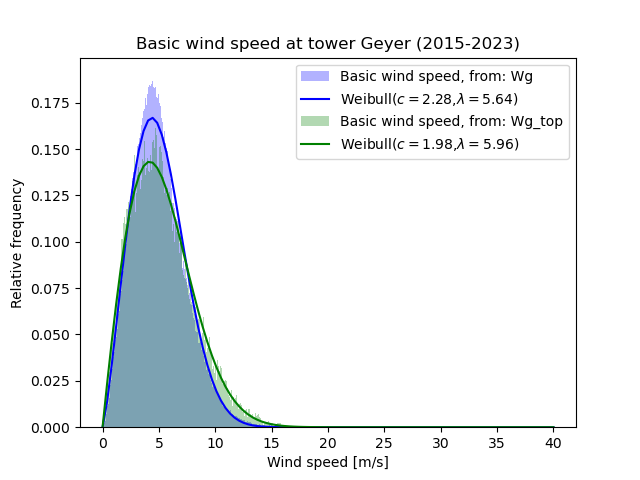

In [40]:
plt.figure()
ax = plt.subplot()
for name, z, color in [('Wg', 100, 'blue'),('Wg_top', 200, 'green')]:
    Wgds = stats_wind.sel(channels=name)
    Wgds = Wgds.where(Wgds['error']==0)
    tenminavg = Wgds['mean'].data           
    var = Wgds['var'].data                             
    ind = np.logical_and(~np.isnan(tenminavg.data), np.log(tenminavg.data)>-2)
    ind = np.logical_and(ind, np.sqrt(var)/tenminavg<=0.5)
    tenminavg = tenminavg[ind]
    var = var[ind]
    Iv = np.sqrt(var)/tenminavg

    v_b = tenminavg/0.77/(z/10)**0.22

    ax.hist(v_b, bins=500, density=True, color=color, alpha=0.3, label=f'Basic wind speed, from: {name}')
    
    # Bootstrapping the Weibull Distribution parameters
    n_bs=30
    all_params = np.empty((n_bs, 3))
    for i_bs in range(n_bs):
        all_params[i_bs,:]=scipy.stats.weibull_min.fit(np.random.choice(v_b, v_b.shape[0]//4), floc=0)
    display(np.min(all_params, axis=0), np.max(all_params, axis=0), scipy.stats.pearsonr(all_params[:,0], all_params[:,2]))
    
    param=scipy.stats.weibull_min.fit(v_b, floc=0) # fit the sample data

    x=np.linspace(0,40,100)

    pdf_fitted = scipy.stats.weibull_min.pdf(x, param[0],
                                         # loc=param[1], 
                                         scale=param[2]
                                        ) # fitted distribution

    ax.plot(x,pdf_fitted,color=color, label=f'Weibull($c={param[0]:1.2f}$,$\lambda={param[2]:1.2f}$)')
    display(f'The parameters of the Weibull distribution are estimated from Anemometer {name} as $k={param[0]:1.3f}$ and $\\lambda={param[2]:1.3f}$')
ax.legend()

ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('Relative frequency')
ax.set_title('Basic wind speed at tower Geyer (2015-2023)')
plt.show()

array([1.95464027, 0.        , 5.89752163])

array([2.01653679, 0.        , 6.01879252])

PearsonRResult(statistic=0.30690138712024373, pvalue=0.0018980306352377014)

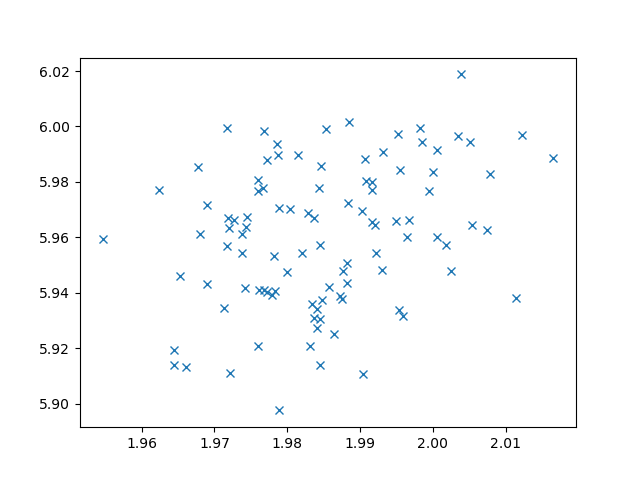

In [43]:
# Bootstrapping the Weibull Distribution parameters
n_bs=100
all_params = np.empty((n_bs, 3))

for i_bs in range(n_bs):
    all_params[i_bs,:]=scipy.stats.weibull_min.fit(np.random.choice(v_b, v_b.shape[0]//4), floc=0)
display(np.min(all_params, axis=0), np.max(all_params, axis=0), scipy.stats.pearsonr(all_params[:,0], all_params[:,2]))
plt.figure()
plt.plot(all_params[:,0],all_params[:,2], ls='none', marker='x')

### Naive implementation

In [ ]:
plt.figure()
plt.plot(I_v, x_grid)
plt.xlabel('$I_v$')
plt.ylabel('$x$')
plt.figure()
plt.plot(v_m,x_grid)
plt.plot(v_m_,x_grid)
plt.xlabel('$v_m$')
plt.ylabel('$x$')
plt.figure()
plt.plot(L, x_grid)
plt.xlabel('$L$')
plt.ylabel('$x$')

In [ ]:
fig, ax = plt.subplots()
mappable = ax.imshow(S_uu, origin='lower',extent=(np.log10(f_w)[0,1], np.log10(f_w)[0,-1], x_grid[0], x_grid[-1]), aspect='auto')
fig.colorbar(mappable)
ax.set_xlabel('f_{log}')
ax.set_ylabel('z')
ax.set_title('logitudinal turbulence spectrum')
fig, ax = plt.subplots()
mappable = ax.imshow(S_vv, origin='lower',extent=(np.log10(f_w)[0,1], np.log10(f_w)[0,-1], x_grid[0], x_grid[-1]), aspect='auto')
fig.colorbar(mappable)
ax.set_xlabel('f_{log}')
ax.set_ylabel('z')
ax.set_title('lateral turbulence spectrum')
fig, ax = plt.subplots()
# mappable = ax.imshow(S_ww, origin='lower',extent=(np.log10(f_w)[0,1], np.log10(f_w)[0,-1], x_grid[0], x_grid[-1]), aspect='auto')
# fig.colorbar(mappable)
# ax.set_xlabel('f_{log}')
# ax.set_ylabel('z')
# ax.set_title('vertical turbulence spectrum')

In [ ]:
S_uu_full = np.zeros((n_z, n_z, n_fw))
S_vv_full = np.zeros((n_z, n_z, n_fw))
S_ww_full = np.zeros((n_z, n_z, n_fw))

# Fourier coefficients of piecewise continuous C_uz 
# by https://www.mathstools.com/section/main/fourier_series_calculator
# A_n = [15.4405939816091,-0.372717716494225,-0.0494689925891682,0.0516149446048229,-0.0592559743893844,-0.117695760790141,-0.0491822700281046,-0.00880307523955097,-0.0588074659485989,-0.0887366147003532,-0.0486113384798025]
# B_n = [0,2.87061180319363,0.319977485969885,0.952596751309051,0.00363958586022834,0.582257254980282,0.111092433110589,0.410398431306736,0.00725137248276886,0.331045157654331,0.0719318349017079]

for i in range(n_z):
    for j in range(i,n_z):
        if i==j: 
            S_uu_full[i,j,:] = S_uu[i,:]
            S_vv_full[i,j,:] = S_vv[i,:]
            # S_ww_full[i,j,:] = S_ww[i,:]
        else:
            # continue
            delta_x = 0
            delta_y = 0
            delta_z = np.abs(x_grid[i] - x_grid[j])
            # if delta_z > 50 : continue
            mean_z = (x_grid[i] + x_grid[j]) / 2
            
            # Piecewise constant decay factors, as in Tab. 4.2. Clobes 2008 -> no positive definite matrix (possibly due to jumps?)
            # if mean_z < 100:
            #     C_uz = 10
            #     C_vz = 7
            # elif mean_z < 150:
            #     C_uz = 6
            #     C_vz = 3
            # else:
            #     C_uz = 5
            #     C_vz = 3
            # if mean_z < 50:
            #     C_wz = 4
            # else:
            #     C_wz = 3
            
            # Fourier series for continuous C_uz, doesn't necesarily make the correlation matrix positive definite
            # C_uz = A_n[0] + B_n[0]
            # for n in range(1,10):
            #     C_uz += A_n[n] * np.cos(mean_z / 202 * 2 * np.pi * n) + B_n[n] * np.sin(mean_z / 202 * 2 * np.pi * n) 
            
            # Linear C_uz, seems to make the correlation matrix positive definite
            # C_uz = -0.025*mean_z + 10
            
            C_uz = 10
            C_vz = 7
            C_wz = 4
            
            coh_u = np.exp(-2 * f_w * C_uz * delta_z / (U_bar[i] + U_bar[j])) 
            r = np.sqrt(coh_u**2 * S_uu[i,:] * S_uu[j,:])
            
            # random phase
            # phi = np.random.random(r.shape)*2*np.pi 
            # Phase information makes it indefinite. 
            # Clobes 2008, p. 51: "ist es im Rahmen baupraktischer Genauigkeit vertretbar, eine Phasendifferenz bei den Kreuzleistungsdichtespektren zu vernachlaessigen"
            
            S_uu_full[i,j,:] = r #* np.exp(1j*phi)
            S_uu_full[j,i,:] = r #* np.exp(1j*phi)

            coh_v = np.exp(-2 * f_w * C_vz * delta_z / (U_bar[i] + U_bar[j])) 
            r = np.sqrt(coh_v**2 * S_vv[i,:] * S_vv[j,:])
            S_vv_full[i,j,:] = r
            S_vv_full[j,i,:] = r

            coh_w = np.exp(-2 * f_w * C_wz * delta_z / (U_bar[i] + U_bar[j]))
            r = np.sqrt(coh_w**2 * S_ww[i,:] * S_ww[j,:])
            S_ww_full[i,j,:] = r
            S_ww_full[j,i,:] = r
            
if f_w[0,0] == 0:
    # S_uu_full[:,:,0] = np.diag(U_bar[:,0])
    S_uu_full[:,:,0] = np.eye(n_z)*1e-10
    S_vv_full[:,:,0] = np.eye(n_z)*1e-10
    S_ww_full[:,:,0] = np.eye(n_z)*1e-10

In [ ]:

plt.figure()

plt.plot(f_w.squeeze(),coh_u.squeeze())

In [ ]:
# Decompose Cross-spectral densities

S_uu_chol = np.empty_like(S_uu_full)
S_vv_chol = np.empty_like(S_vv_full)
S_ww_chol = np.empty_like(S_ww_full)

for k in range(n_fw):

    # Conditioning options:
    
    # Higham, 2002:
    # from nearest_correlation import nearcorr
    # S_uu_cond = nearcorr(S_full[:,:,k])
    
    # remove rows and columns
    #S_uu_cond = S_full[:3,:3,k]
    
    # remove outer diagonals -> marginal effect
    # S_uu_cond = np.diag(np.diag(S_full[:,:,k]))
    # for k_ in range(1,10):
    #     S_uu_cond += np.diag(np.diag(S_full[:,:,k], k=k_),k=k_)
    #     S_uu_cond += np.diag(np.diag(S_full[:,:,k], k=-k_),k=-k_)
    
    # remove or increase negative eigenvalues -> they reappear in small magnitude
    # w,v = np.linalg.eig(S_full[:,:,k])
    # eps = np.finfo(float).eps
    # eps = 0
    # # remove eigenvalues
    # if True:
    #     v_ = v[:,w>eps]
    #     w_ = w[w>eps]
    # # increase eigenvalue magnitude
    # else:
    #     w_ = w
    #     v_ = v - v.min()
    # S_cond = v_ @ np.diag(w_) @ v_.T
    
    try:
        S_uu_chol[:,:,k] = np.linalg.cholesky(S_uu_full[:,:,k])
        S_vv_chol[:,:,k] = np.linalg.cholesky(S_vv_full[:,:,k])
        S_ww_chol[:,:,k] = np.linalg.cholesky(S_ww_full[:,:,k])
        
    # catch non-positive definite correlation matrices
    except Exception as e:
        print(e)

In [ ]:
# Generate time series by inverse Real FFT

# Theta_jm = 0 for all f (Delta_x = 0)

c_uj = np.zeros((n_z, n_fw), dtype=complex)
c_vj = np.zeros((n_z, n_fw), dtype=complex)
c_wj = np.zeros((n_z, n_fw), dtype=complex)

u_j = np.zeros((n_z, 2*(n_fw - 1)))
v_j = np.zeros((n_z, 2*(n_fw - 1)))
w_j = np.zeros((n_z, 2*(n_fw - 1)))

delta_fw = f_w[0, 1] - f_w[0, 0]
for j in range(n_z):
    for m in range(j+1):
        c_uj[j] += 1/2 * np.abs(S_uu_chol[j, m, :])  * np.sqrt(delta_fw*2*np.pi) * np.exp(1j * phi_um[m, :])
        
        c_vj[j] += 1/2 * np.abs(S_vv_chol[j, m, :])  * np.sqrt(delta_fw*2*np.pi) * np.exp(1j * phi_vm[m, :])
        
        c_wj[j] += 1/2 * np.abs(S_ww_chol[j, m, :])  * np.sqrt(delta_fw*2*np.pi) * np.exp(1j * phi_wm[m, :])
        
        
    u_j[j,:] = np.fft.irfft(c_uj[j,:], norm="forward") # "backward", "ortho", "forward"
    v_j[j,:] = np.fft.irfft(c_vj[j,:], norm="forward") # "backward", "ortho", "forward"
    w_j[j,:] = np.fft.irfft(c_wj[j,:], norm="forward") # "backward", "ortho", "forward"

In [ ]:
vmin = min([u_j.min(), v_j.min(), w_j.min()])
vmax = max([u_j.max(), v_j.max(), w_j.max()])

plt.matshow(u_j, origin='lower', aspect='auto', extent=(0, f_w.shape[1]/fs_w, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax)
plt.xlabel('time [s]')
plt.ylabel('height [m]')
cbar = plt.colorbar()
cbar.set_label('Turbulence $V_u$ [m/s]')
plt.matshow(v_j, origin='lower', aspect='auto', extent=(0, f_w.shape[1]/fs_w, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax)
plt.xlabel('time [s]')
plt.ylabel('height [m]')
cbar = plt.colorbar()
cbar.set_label('Turbulence $V_v$ [m/s]')
plt.matshow(w_j, origin='lower', aspect='auto', extent=(0, f_w.shape[1]/fs_w, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax)
plt.xlabel('time [s]')
plt.ylabel('height [m]')
cbar = plt.colorbar()
cbar.set_label('Turbulence $V_w$ [m/s]')

### Windfield animation

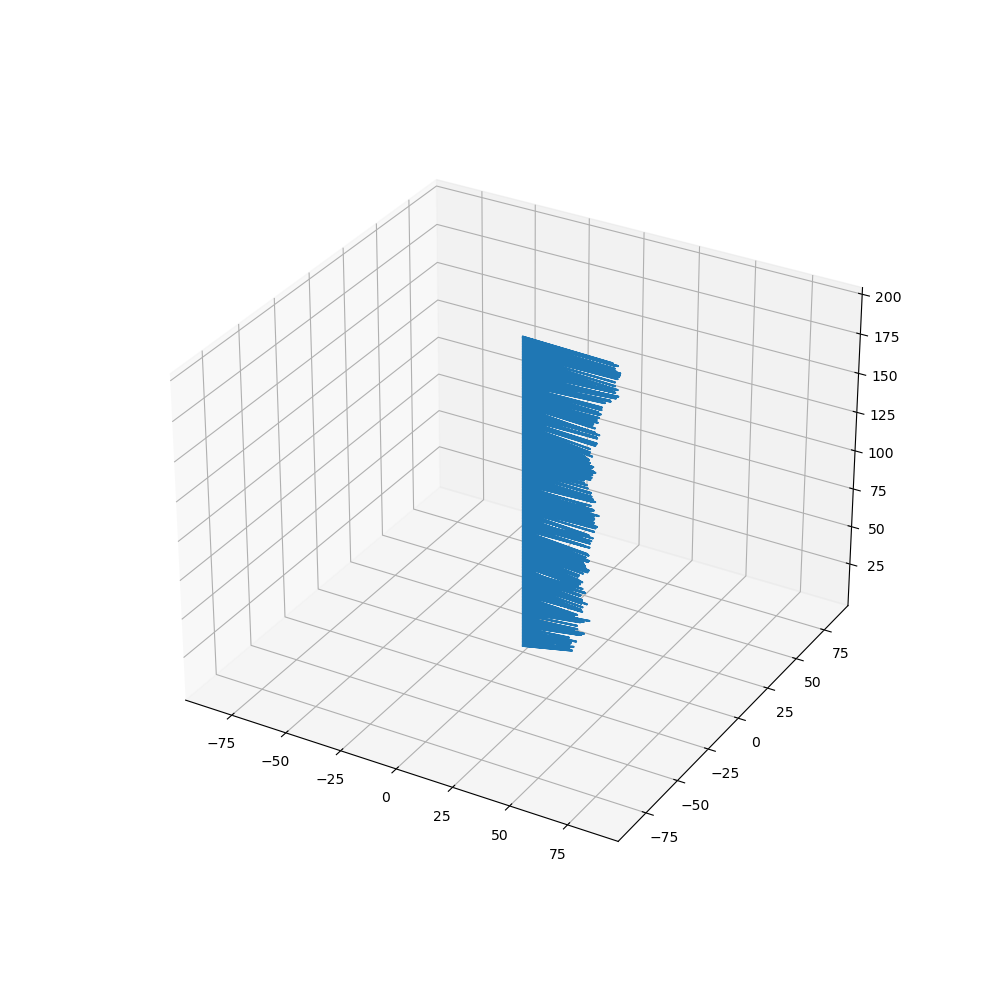

In [19]:
plt.close('all')
del ani

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
z = x_grid
zero = np.zeros_like(z)
# to run GUI event loop

u_j_ += v_m[np.newaxis, :]
u_j_inter = np.empty((3*n_z,), dtype=u_j.dtype)
u_j_inter[0::3] = zero
u_j_inter[1::3] = u_j_[0, :]
u_j_inter[2::3] = zero

v_j_inter = np.empty((3*n_z,), dtype=v_j.dtype)
v_j_inter[0::3] = zero
v_j_inter[1::3] = v_j[0, :]
v_j_inter[2::3] = zero

x_grid_inter = np.empty((3*n_z,), dtype=x_grid.dtype)
x_grid_inter[0::3] = x_grid
x_grid_inter[1::3] = x_grid
x_grid_inter[2::3] = x_grid

zero_inter = np.empty((3*n_z,), dtype=zero.dtype)
zero_inter[0::3] = zero
zero_inter[1::3] = zero
zero_inter[2::3] = zero

lines = ax.plot(u_j_inter, v_j_inter, x_grid_inter)[0]

lim = np.max([-np.min(u_j), np.max(u_j), -np.min(v_j), np.max(v_j)])*2
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))

def update(n):
    u_j_inter[1::3] = u_j_[n, :]
    v_j_inter[1::3] = v_j[n, :]
    lines.set_data(u_j_inter, v_j_inter)
    lines.set_3d_properties(x_grid_inter)
    return lines

ani = FuncAnimation(fig, update, frames=N_m, blit=True, interval=33)
plt.show()   

In [20]:
ani.pause()
ani._stop()
plt.close('all')
del ani

In [21]:
ani = None

### gemitteltes Spektrum

Text(0, 0.5, 'S_vv [m/s/Hz]')

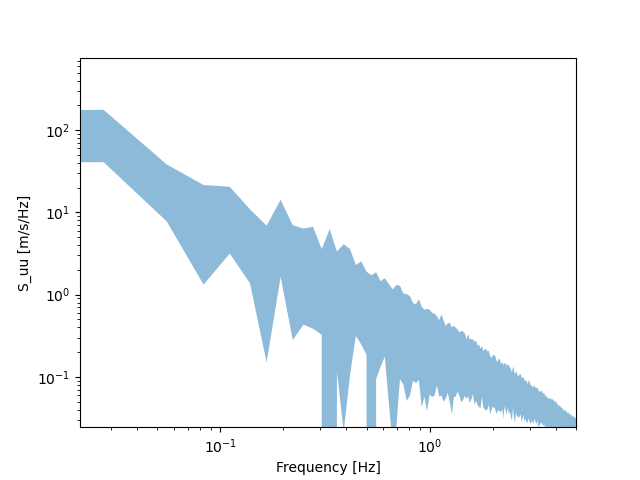

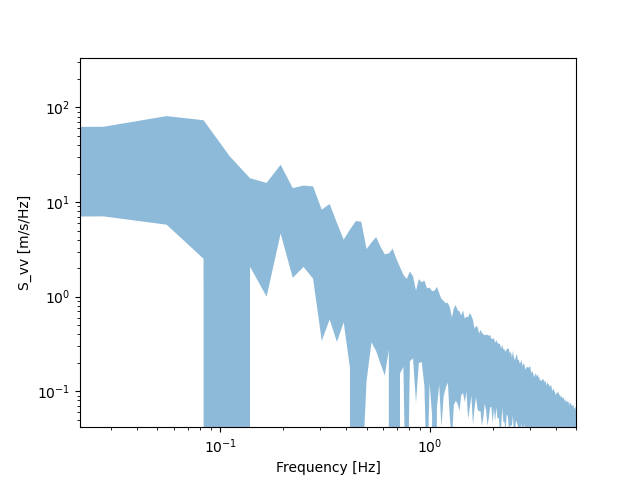

In [22]:
smin = min([np.abs(c_uj).min(), np.abs(c_vj).min()])#, w_j.min()])
smax = max([np.abs(c_uj).max(), np.abs(c_vj).max()])#, w_j.max()])

s_uj_av = np.mean(np.abs(c_uj)**2, axis=1)
s_uj_sig = np.std(np.abs(c_uj)**2, axis=1)

plt.figure()
plt.fill_between(f_w.squeeze(), s_uj_av-s_uj_sig,s_uj_av+s_uj_sig, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(xmax=fs_w/2)
plt.ylim(ymin=s_uj_av[-1])
plt.xlabel('Frequency [Hz]')
plt.ylabel('S_uu [m/s/Hz]')

s_vj_av = np.mean(np.abs(c_vj)**2, axis=1)
s_vj_sig = np.std(np.abs(c_vj)**2, axis=1)

plt.figure()
plt.fill_between(f_w.squeeze(), s_vj_av-s_vj_sig,s_vj_av+s_vj_sig, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(xmax=fs_w/2)
plt.ylim(ymin=s_vj_av[-1])
plt.xlabel('Frequency [Hz]')
plt.ylabel('S_vv [m/s/Hz]')

(0.0, 5.0)

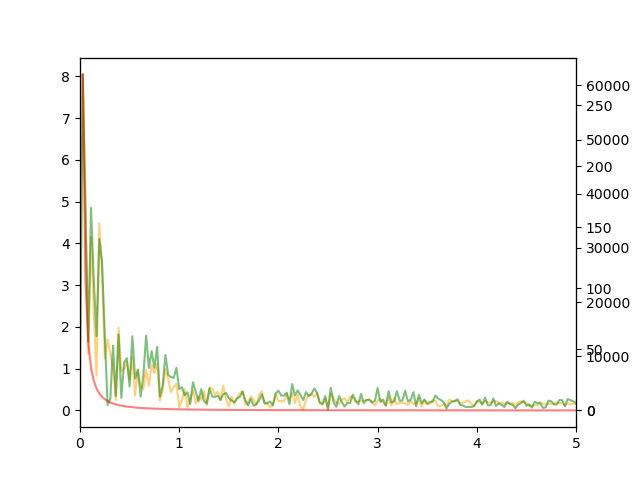

In [23]:
f_m = np.fft.rfftfreq(N_m, 1/fs_m)[:, np.newaxis]
plt.close('all')
plt.figure()


plt.plot(f_w.squeeze(), np.abs(c_uj[:, -1]), alpha=0.5, c='orange')

ax = plt.gca()
ax.twinx().plot(np.fft.rfftfreq(N_m, 1/fs_m), np.abs(np.fft.rfft(F_uj[:, -1])), c='g', alpha=0.5)
# ax.twinx().plot(np.fft.rfftfreq(N_m, 1/fs_m), np.abs(np.fft.rfft(u_j[-1,:])), c='g', alpha=0.5)
ax.twinx().plot(f_w.squeeze(), S_uu[:, -1], c='r', alpha=0.5)
ax.set_xlim((0,5))
# ax.set_yscale('log')